In [7]:
!pip install --quiet hdmedians

In [254]:
import numpy as np
import pandas as pd
import seaborn as sns
from lib.utils import *
from copy import deepcopy

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 7]

def get_repo_name(i):
    """Get id from lookup... then get name from bigquery table? """
    pass
    
def predict_ai(model, pos, X):
    """ pos is the positive class vectors, X is the entire dataset """    
    model = deepcopy(model)
    model.fit(pos)
    preds = model.predict(X)
    return np.argwhere(preds == 1)

def print_random(pos, amt=30):
    print('Printing {}/{} positive documents'.format(amt, len(pos)))
    np.random.shuffle(pos)
    for p in pos[0:30]: 
        print(get_sentence(p[0]))

In [9]:
size = int(5472100/2)
embeddings = get_embeddings('./ss/ss_repo_embeds.txt', size)

In [ ]:
# repos = [
#     'GuessWhatGame/vqa',
#     'gitlimlab/SSGAN-Tensorflow',
#     'mufarhan/sequence_class_NIPS_2017',
#     'KeiraZhao/SPN',
#     'ap229997/Conditional-Batch-Norm'
# ]

with open('old_nips_repos.txt', 'r') as f: 
    repos = [l.strip() for i,l in enumerate(f)]
        
write_ai_readmes(repos, 'prepared-readmes/old-ai-readmes.txt')

In [5]:
# USE STARSPACE TO WRITE VECTORS FROM THESE TEXTS
# bash scripts/embed-ai-readmes.sh prepared-readmes/ai-readmes.txt ss/ai-vectors.txt

In [10]:
vecs = np.array(get_ss_embed('ss/old-ai-vectors.txt'))

## Visualize Embedded Space

In [245]:
from scipy.spatial.distance import euclidean, cosine
from hdmedians import geomedian, medoid

def distances_from_med(vecs, embeddings):
    """ Generate distance of each embedding from medoid of vecs """
    med = np.asarray(medoid(vecs.T))
    dist = lambda d: euclidean(d, med)
    distances = np.apply_along_axis(lambda d: euclidean(d, med), 1, embeddings)
    return distances

def pick_local_sample(distances, embedding, sample_size, thresh):
    s = embeddings[distances < thresh]
    idx = np.random.choice(s.shape[0], sample_size, replace=False)
    sample = s[idx]
    return sample

In [235]:
distances = distances_from_med(vecs, embeddings)

## One-Class SVM

In [262]:
from sklearn.svm import OneClassSVM

svm = OneClassSVM(kernel='rbf', nu = .5, gamma = 1/1000)

In [256]:
from sklearn.manifold import MDS, Isomap, LocallyLinearEmbedding, TSNE

def project(embeddings, vecs):
    mds = MDS()
    X = np.concatenate([embeddings, vecs])
    manifold = model.fit_transform(X)
    labels = np.concatenate([np.zeros(embeddings.shape[0]), np.ones(vecs.shape[0])])
    df = pd.DataFrame(manifold, columns = ['x', 'y']).assign(source = pd.Series(labels))
    return df
    
def plot_predictions(model, df):
    X = df[['x', 'y']].values
    vecs = X[df.source == 1]
    pos = predict_ai(model, vecs, X)
    taken = [p[0] for p in pos]
    lab = np.array(['Papers' if i == 1 else 'Random' for i in df.source])
    lab[taken] = 'Classified'
    df['label'] = lab
    sns.scatterplot(x = 'x', y = 'y', style='source', hue = 'label', data = df, palette="Set1")

In [263]:
sample = pick_local_sample(distances, embeddings, sample_size=500, thresh=1.2)

In [264]:
df = project(sample, vecs)

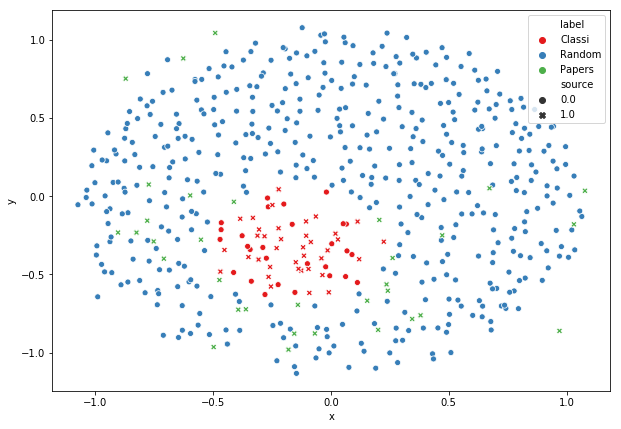

In [265]:
plot_predictions(svm, df)

In [266]:
pos = predict_ai(svm, vecs, embeddings)
len(vecs), len(pos)

(73, 5981)

In [ ]:
print_random(pos)

## Isolation Forest

Performs poorly!! Contamination too low? No real advantage in theory.... 

In [5]:
from sklearn.ensemble import IsolationForest

forest = IsolationForest(n_jobs=-1)
pos = predict_ai(forest, vecs, embeddings)

In [6]:
len(vecs), len(pos)

(73, 64998)

In [ ]:
print_random(pos)